In [16]:
%matplotlib notebook

import numpy as np
import matplotlib
matplotlib.use('tkagg')
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from matplotlib.widgets import Slider, Button, RadioButtons
from mpl_toolkits.mplot3d.axes3d import Axes3D

def rk4(R,V,a,h,ring_r,ring_steps,q):
	# Function to time step using the Runge-Kutta 4th order algorithm
	# V - velocity vector of the particle(s)
	# R - position vector of the particle(s)
	# a - function which outputs the acceleration of the particle
	# h - time step size
	# ring_r,ring_steps,q - parameters used in the a() function

	# First
	r_1 = R
	v_1 = V
	a_1 = a(r_1,ring_r,ring_steps,q)

	# Second
	r_2 = r_1 + 0.5*v_1*h
	v_2 = v_1 + 0.5*a_1*h
	a_2 = a(r_2,ring_r,ring_steps,q)

	# Third
	r_3 = r_1 + 0.5*v_2*h
	v_3 = v_1 + 0.5*a_2*h
	a_3 = a(r_3,ring_r,ring_steps,q)

	# Fourth
	r_4 = r_1 + v_3*h
	v_4 = v_1 + a_3*h
	a_4 = a(r_4,ring_r,ring_steps,q)

	# Final position and velocity
	r_f = R + (h/6.0)*(v_1+2*v_2+2*v_3+v_4)
	v_f = V + (h/6.0)*(a_1+2*a_2+2*a_3+a_4)

	return r_f,v_f

def a(R,ring_r,ring_steps,q):
	# Function to calculate the acceleration of the particle(s) at position R
	# R - position vector of the the particle(s)
	# ring_r -  radius of the charged ring
	# q - ratio of the charge on the particle to that on the ring
	# ring_steps - Number of sections of ring considered	

	# Charge density of the ring
	rho = q/(2*np.pi*ring_r)

	# Azimuthal angle steps
	phi_h = 2*np.pi/float(ring_steps)
	
	total_acc = np.array((0.0,0.0,0.0))
	for i in range(ring_steps):
		# Azimuthal angle
		phi = i*phi_h
		# Relative position vector of particle to element of ring dq
		P = R-np.array((ring_r*np.cos(phi),ring_r*np.sin(phi),0))
	
		# Magnitude of the relative position vector
		P_mag = np.linalg.norm(P)

		acc = -ring_r*phi_h*rho*P/(4*np.pi*P_mag**3)

		total_acc = total_acc + acc

	return total_acc

def shm_freq(ring_r,q):
	return (q/(4*np.pi*ring_r**3))**0.5

In [20]:
class Animation(object):

	def __init__(self,q,ring_r,ring_steps,h,N,N_output):
		self.q = q
		self.ring_r = ring_r
		self.ring_steps = ring_steps
		self.h = h
		self.N = N
		self.N_output = N_output

	def create_plot(self,R_i,V_i):
		self.R_i = R_i
		self.V_i = V_i

		self.fig = plt.figure(figsize = plt.figaspect((0.5)))

		self.ax1 = self.fig.add_subplot(1,2,1, projection='3d')
		self.ax1.set_xlim3d([-self.ring_r,self.ring_r])
		self.ax1.set_ylim3d([-self.ring_r,self.ring_r])
		self.ax1.set_zlim3d([-1.5*self.R_i[2],1.5*self.R_i[2]])
		for i in range(self.ring_steps):
			phi_h = 2*np.pi/float(self.ring_steps)
			x = self.ring_r*np.cos(i*phi_h)
			y = self.ring_r*np.sin(i*phi_h)
			self.ax1.plot([x],[y],[0.0],'bo')

		self.ax2 = self.fig.add_subplot(1,2,2)
		z_max = self.R_i[2]
		self.ax2.set_xlim([0.0,self.h*self.N])
		self.ax2.set_ylim([-z_max,z_max])

		self.particle = self.ax1.plot([self.R_i[0]],[self.R_i[1]],[self.R_i[2]],'ro')[0]
		self.z_plot = self.ax2.plot([0.0],[z_max],'b-')[0]
		self.z_shm = self.ax2.plot([0.0],[z_max],'r-')[0]

	def create_sliders(self):
		# Positioning of sliders
		axp_s = 0.02
		# Slider index
		si = 0
		# Slider width
		sw = 0.02
		
		# Starting height of particle slider
		self.ax_h = plt.axes([0.15,axp_s+si*(0.01+sw),0.65,sw])
		self.s_h = Slider(self.ax_h,'Particle Height',0.001,5.0, valinit= self.R_i[2])
		self.s_h.on_changed(self.update)
		si = si+1

		# Charge factor slider
		self.ax_q = plt.axes([0.15,axp_s+si*(0.01+sw),0.65,sw])
		self.s_q = Slider(self.ax_q,'Charge Factor',100.0,10000.0, valinit = self.q)
		self.s_q.on_changed(self.update)
		si = si+1

		# Run button
		self.ax_b = plt.axes([0.15,1.0 - (0.04+sw),0.65,1.5*sw])
		self.b_run = Button(self.ax_b,'Run (with new values)')
		self.b_run.on_clicked(self.mainloop)
		
		plt.show()

	def run_anim(self,R_rec,V_rec):

		self.R = R_rec
		self.V = V_rec
		self.ax2.set_ylim([-self.R_i[2],self.R_i[2]])
		self.ax1.set_zlim3d([-1.5*self.R_i[2],1.5*self.R_i[2]])
		self.shm_f = shm_freq(self.ring_r,self.q)

		# Animation functions
		def nextframe(arg):
			self.particle.set_data(self.R[0:2,arg])
			self.particle.set_3d_properties(self.R[2,arg])

			frame_num = arg+1
			time = np.linspace(0.0,self.h*self.N_output*arg,frame_num)
			self.z_plot.set_data(time,self.R[2,:frame_num])
			self.z_shm.set_data(time,self.R[2,0]*np.cos(self.shm_f*time))
		try:
			self.animate._stop()
		except:
			print('No FuncAnimation to stop')
		self.animate = anim.FuncAnimation(self.fig, nextframe, self.N/self.N_output, interval = 100, blit = False)
		plt.show()

	def update(self,val):
		self.q = self.s_q.val
		self.R_i = np.array((0.0,0.0,self.s_h.val))

	def mainloop(self,event):
		print('Commencing RK4 routine...')
		
		R = np.zeros((3))
		V = np.zeros((3))
		R = self.R_i
		V = self.V_i

		# Record arrays:
		R_rec = np.zeros((3,N/N_output))
		V_rec = np.zeros((3,N/N_output))
		i_rec = 0
		for i in range(N):
			R,V = rk4(R,V,a,self.h,self.ring_r,self.ring_steps,self.q)
			if (i%N_output) == 0:
				R_rec[:,i_rec] = R
				V_rec[:,i_rec] = V
				i_rec = i_rec + 1	

		print('RK4 time stepping has been completed')

		self.run_anim(R_rec,V_rec)

<IPython.core.display.Javascript object>


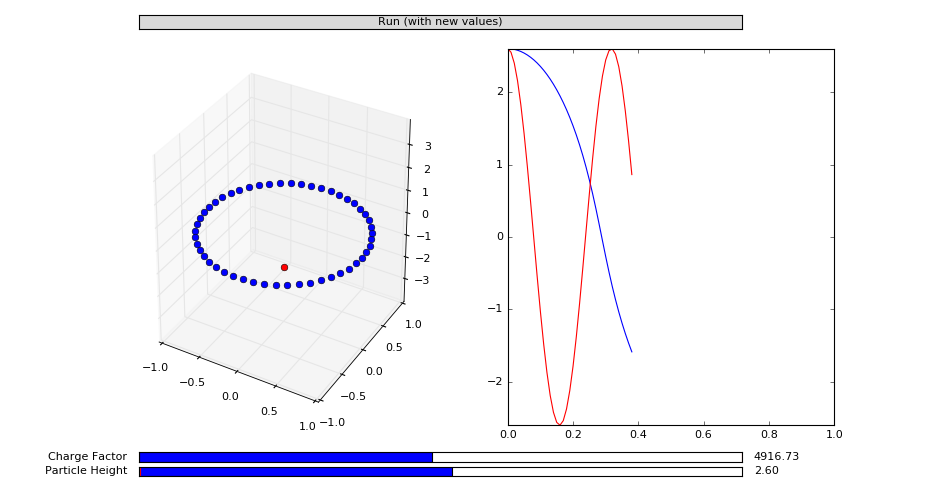

In [21]:
if __name__ == "__main__":
	# initial conditions
	# Particle position and velocity
	R = np.array((0.0,0.0,0.01))
	V = np.array((0.0,0.0,0.0))

	# Ring radius
	ring_r = 1.0
	# Ring sections
	ring_steps = 50
	# Charge factor = qQ/epsilon_0
	q = 10000.0

	# Time step
	h = 10.0**-3
	N = 1000

	# Animation frame change
	N_output = 10

	Anim = Animation(q,ring_r,ring_steps,h,N,N_output)
	Anim.create_plot(R,V)
	Anim.create_sliders()